# KBDI and Drought Factor (DF) Computation

This notebook calculates the **Keetch–Byram Drought Index (KBDI)** and the **Drought Factor (DF)** for New South Wales forest regions using **pre‑processed daily precipitation GeoTIFFs** (and temperature where required).  
All input rasters have already been:

* spatially aligned to a common grid,
* clipped to the study area, and
* checked for missing dates.

> **Workflow outline**  
> 1. Read the daily precipitation (and temperature) rasters from disk.  
> 2. Compute KBDI for each day and write GeoTIFFs to `.../kbdi10`.  
> 3. Derive DF from daily rainfall totals and KBDI, saving rasters to `.../df_final`.  

All headings below use a “Section – Action” naming convention to make the notebook easy to scan.  
Comments have been expanded so that **a user new to fire‑danger climatology can follow the logic step by step**.

## 1 – Compute daily KBDI

In [ ]:
# 1 – Compute daily KBDI
import os
import re
import numpy as np
import xarray as xr
import rioxarray as rxr
from pathlib import Path

# ------------------------------------------------------------------------------
# 1) Define your folder paths as Path objects
# ------------------------------------------------------------------------------
temp_folder  = Path(r"C:/Users/gades/Desktop/Thesis/datasets/Temperature/temp_daily/aligned")
precip_folder = Path(r"C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/mm/mm_final")
output_folder = Path(r"C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/kbdi10")
output_folder.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------------------
# 2) Regex to parse date (YYYY-MM-DD) from filenames
# ------------------------------------------------------------------------------
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")

# Gather & sort temperature files by date
temp_files = sorted(temp_folder.glob("*.tif"))

# Create a dictionary to map date -> precipitation file
precip_dict = {}
for p_file in precip_folder.glob("*.tif"):
    match_p = date_pattern.search(p_file.name)
    if match_p:
        date_str_p = match_p.group(0)
        precip_dict[date_str_p] = p_file

# ------------------------------------------------------------------------------
# 3) Define the KBDI formula (Crane 1982 / Alexander 1990)
# ------------------------------------------------------------------------------
def compute_kbdi_crane(kbdi_prev, temp_c, precip_mm, delta_t=1.0):
    """
    Compute today's KBDI in mm using an adaptation of the formula:

      KBDI_SI(t) = Q_SI + [ (203.2 - Q_SI)
                            * (0.968 e^(0.0875*T + 1.5552) - 8.30) 
                            * t / ( 1 + 10.88 e^(-0.001736 * P) ) ] x 1e-3

    where Q_SI = KBDI_SI(t-1) - P(t).

    :param kbdi_prev: yesterday's KBDI [mm], can be a scalar or DataArray
    :param temp_c: today's max temperature [C], DataArray
    :param precip_mm: today's total precipitation [mm], DataArray
    :param delta_t: time step in days (1.0 for daily)
    :return: today's KBDI [mm] as a DataArray
    """
    # 1) Q_SI = kbdi_prev - precip_mm, but clipped to >= 0 for each pixel
    q_si = kbdi_prev - precip_mm
    q_si = xr.where(q_si < 0, 0.0, q_si)

    # 2) Dryness term
    dryness_term = 0.968 * np.exp(0.0875 * temp_c + 1.5552) - 8.30

    # 3) Denominator
    denom = 1.0 + 10.88 * np.exp(-0.001736 * precip_mm)

    # 4) Combine
    kbdi_today = q_si + ((203.2 - q_si) * dryness_term * delta_t / denom) * 1e-3

    # 5) Clip final KBDI to [0, 203.2] for each pixel
    kbdi_today = xr.where(kbdi_today < 0, 0.0, kbdi_today)
    kbdi_today = xr.where(kbdi_today > 203.2, 203.2, kbdi_today)

    return kbdi_today

# ------------------------------------------------------------------------------
# 4) Main loop: Pair temperature & precipitation daily, compute KBDI
# ------------------------------------------------------------------------------
kbdi_prev = 0.0  # Start day 1 with KBDI=0 mm or a known baseline

for t_file in temp_files:
    # Parse date from temperature file
    match_t = date_pattern.search(t_file.name)
    if not match_t:
        print(f" Could not parse date in {t_file.name}, skipping.")
        continue

    date_str_t = match_t.group(0)
    p_file = precip_dict.get(date_str_t)
    if not p_file:
        print(f" No matching precipitation file for {t_file.name} => {date_str_t}, skipping.")
        continue

    print(f"\n Processing: {t_file.name} & {p_file.name}")

    # 4.1) Open temperature & precipitation rasters
    temp_da = rxr.open_rasterio(t_file)
    precip_da = rxr.open_rasterio(p_file)

    # (Optional) Assign or check CRS if missing:
    # if temp_da.rio.crs is None:
    #     temp_da.rio.write_crs("EPSG:4326", inplace=True)
    # if precip_da.rio.crs is None:
    #     precip_da.rio.write_crs("EPSG:4326", inplace=True)

    # 4.2) Reproject precipitation if shapes differ
    if precip_da.rio.shape != temp_da.rio.shape:
        print(f"    Shape mismatch! Resampling precipitation from {precip_da.rio.shape} to {temp_da.rio.shape}...")
        precip_da = precip_da.rio.reproject_match(temp_da)

    # 4.3) Compute KBDI for every pixel
    temp_c = temp_da.squeeze()
    p_mm = precip_da.squeeze()

    # If we want a "per-pixel" KBDI, kbdi_prev must be a 2D DataArray
    # from the previous iteration. If it's just a float, we create a 2D array
    if not isinstance(kbdi_prev, xr.DataArray):
        kbdi_prev_da = temp_c.copy(deep=True)
        kbdi_prev_da.data[:] = kbdi_prev
        kbdi_prev_da.rio.write_crs(temp_da.rio.crs, inplace=True)
    else:
        kbdi_prev_da = kbdi_prev

    # Compute the new KBDI for each pixel
    kbdi_array = compute_kbdi_crane(kbdi_prev_da, temp_c, p_mm)

    # 4.4) Convert the result into a DataArray
    kbdi_today = kbdi_prev_da.copy(deep=True)
    kbdi_today.data = kbdi_array

    # 4.5) Write CRS/transform
    kbdi_today.rio.write_crs(temp_da.rio.crs, inplace=True)
    kbdi_today.rio.write_transform(temp_da.rio.transform(), inplace=True)

    # 4.6) Check if kbdi_today has valid pixels
    height, width = kbdi_today.rio.shape
    valid_pixels = kbdi_today.count().item()
    if (height == 0) or (width == 0) or (valid_pixels == 0):
        print(f"    KBDI for {t_file.name} is empty. Skipping write.")
        continue

    # 4.7) Save daily KBDI
    out_name = f"KBDI_{t_file.name}"
    output_path = output_folder / out_name
    kbdi_today.rio.to_raster(output_path)
    print(f"    Saved KBDI file: {output_path}")

    # 4.8) Update kbdi_prev for tomorrow
    kbdi_prev = kbdi_today

print("\n All done computing KBDI (Crane/Alexander)!")


## 2 – Compute daily Drought Factor (DF)

In [18]:
# 2 – Compute daily Drought Factor (DF)
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling

#  Define dataset folders
precipitation_folder ="C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/mm/mm_final"# Folder with precipitation TIFFs
kbdi_folder = "C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/kbdi10"  # Folder with KBDI TIFFs
output_folder = "C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final"# Output folder for DF TIFFs
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

#  Get sorted list of TIFF files
precip_files = sorted([f for f in os.listdir(precipitation_folder) if f.endswith(".tif")])
kbdi_files = sorted([f for f in os.listdir(kbdi_folder) if f.endswith(".tif")])

#  Ensure both folders contain the same number of files
if len(precip_files) != len(kbdi_files):
    print(f" Warning: Different file counts! {len(precip_files)} in Precipitation vs {len(kbdi_files)} in KBDI")

# Function to calculate x (rainfall effect)
def compute_x(P, N):
    """Compute x based on previous rainfall N and current rainfall P (element-wise)."""
    x = np.ones_like(P)  # Default x = 1

    # Condition where N <= 1 and P > 2
    mask1 = (N <= 1) & (P > 2)
    x[mask1] = (N[mask1] ** 1.3) / ((N[mask1] ** 1.3) + (P[mask1] - 2))

    # Special case where N == 0 and P > 2
    mask2 = (N == 0) & (P > 2)
    x[mask2] = (0.8 ** 1.3) / ((0.8 ** 1.3) + (P[mask2] - 2))

    return x

#  Process each precipitation-KBDI pair
prev_rainfall = None  # Store previous rainfall data for computing x
for precip_file, kbdi_file in zip(precip_files, kbdi_files):
    precip_path = os.path.join(precipitation_folder, precip_file)
    kbdi_path = os.path.join(kbdi_folder, kbdi_file)
    output_path = os.path.join(output_folder, f"DF_{precip_file}")

    print(f"\n Processing: {precip_file} & {kbdi_file}")

    #  Open precipitation and KBDI files
    with rasterio.open(precip_path) as precip_src, rasterio.open(kbdi_path) as kbdi_src:
        precip_data = precip_src.read(1)
        kbdi_data = kbdi_src.read(1)

        # Handle NoData values
        precip_data[precip_data == precip_src.nodata] = np.nan
        kbdi_data[kbdi_data == kbdi_src.nodata] = np.nan

        # Initialize previous rainfall
        if prev_rainfall is None:
            prev_rainfall = np.zeros_like(precip_data)  # Initial zero rainfall

        # Compute x (rainfall effect)
        x = compute_x(precip_data, prev_rainfall)

        #  Compute Drought Factor (DF) using the formula
        DF = 10.5 * (1 - np.exp(-(kbdi_data + 30) / 40)) * ((41 * x**2 + x) / (40 * x**2 + x + 1))

        # Store current rainfall for next iteration
        prev_rainfall = precip_data.copy()

        #  Save DF raster
        output_meta = precip_src.meta.copy()
        output_meta.update({
            "driver": "GTiff",
            "dtype": "float32",
            "nodata": np.nan
        })

        with rasterio.open(output_path, "w", **output_meta) as dst:
            dst.write(DF, 1)

    print(f" Saved DF file: {output_path}")

print("\n Drought Factor Calculation Complete!")


🔍 Processing: filled_precipitation_2013-01-01_mm.tif & KBDI_aligned_t2m_dailymax_2019-01-01_cel.tif
✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-01-01_mm.tif

🔍 Processing: filled_precipitation_2013-01-02_mm.tif & KBDI_aligned_t2m_dailymax_2019-01-02_cel.tif
✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-01-02_mm.tif

🔍 Processing: filled_precipitation_2013-01-03_mm.tif & KBDI_aligned_t2m_dailymax_2019-01-03_cel.tif
✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-01-03_mm.tif

🔍 Processing: filled_precipitation_2013-01-04_mm.tif & KBDI_aligned_t2m_dailymax_2019-01-04_cel.tif
✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-01-04_mm.tif

🔍 Proce

C:\Users\gades\AppData\Local\Temp\ipykernel_51188\3257348261.py:27: RuntimeWarning: invalid value encountered in power
  x[mask1] = (N[mask1] ** 1.3) / ((N[mask1] ** 1.3) + (P[mask1] - 2))


✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-07-29_mm.tif

🔍 Processing: filled_precipitation_2013-07-30_mm.tif & KBDI_aligned_t2m_dailymax_2019-07-30_cel.tif
✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-07-30_mm.tif

🔍 Processing: filled_precipitation_2013-07-31_mm.tif & KBDI_aligned_t2m_dailymax_2019-07-31_cel.tif
✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-07-31_mm.tif

🔍 Processing: filled_precipitation_2013-08-01_mm.tif & KBDI_aligned_t2m_dailymax_2019-08-01_cel.tif
✅ Saved DF file: C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final\DF_filled_precipitation_2013-08-01_mm.tif

🔍 Processing: filled_precipitation_2013-08-02_mm.tif & KBDI_aligned_t2m_dailymax_2019-08-02_cel.tif
✅ Saved 

## 3 – Summarise daily KBDI statistics

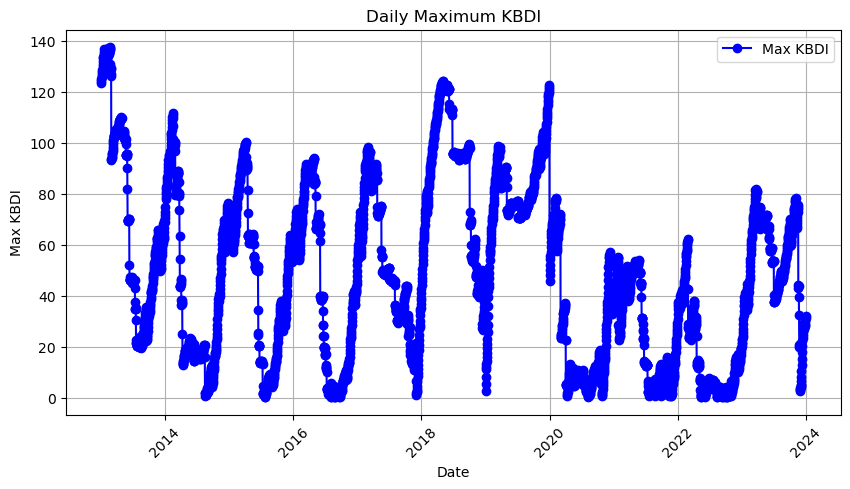

In [7]:
# 3 – Summarise daily KBDI statistics
import os
import re
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Folder containing the KBDI TIFF files
folder_path = ("C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/kbdi10") # Change this to your folder path

# Regular expression pattern to extract date from filename (modify as needed)
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")  # Assumes YYYY-MM-DD format in filename

# Dictionary to store max KBDI values
kbdi_data = {}

# Process each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):  # Ensure it's a .tif file
        match = date_pattern.search(filename)
        if match:
            date_str = match.group()
            date = datetime.strptime(date_str, "%Y-%m-%d").date()
            
            # Open the raster file
            file_path = os.path.join(folder_path, filename)
            with rasterio.open(file_path) as dataset:
                kbdi_array = dataset.read(1)  # Read the first band
                kbdi_max = np.nanmax(kbdi_array)  # Get the max KBDI value
                
                # Store max value for the date
                kbdi_data[date] = kbdi_max

# Convert to Pandas DataFrame
df = pd.DataFrame(list(kbdi_data.items()), columns=["Date", "Max KBDI"])
df.sort_values("Date", inplace=True)

# Plot the max KBDI values over time
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Max KBDI"], marker="o", linestyle="-", color="b", label="Max KBDI")
plt.xlabel("Date")
plt.ylabel("Max KBDI")
plt.title("Daily Maximum KBDI")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.savefig("kbdi_plot.png", dpi=150)
plt.show()


## 4 – Summarise daily DF statistics

C:\Users\gades\AppData\Roaming\Python\Python39\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


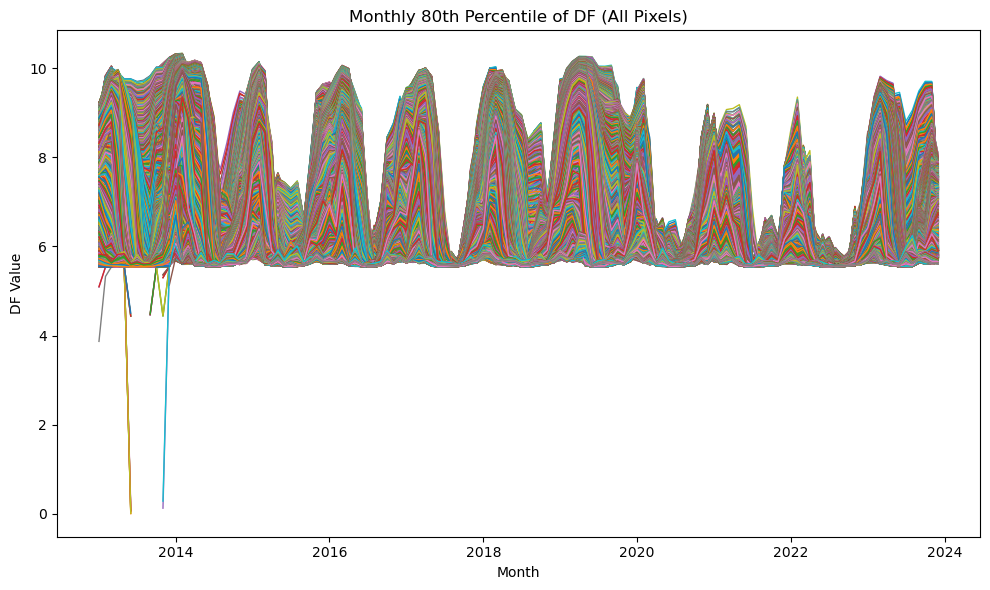

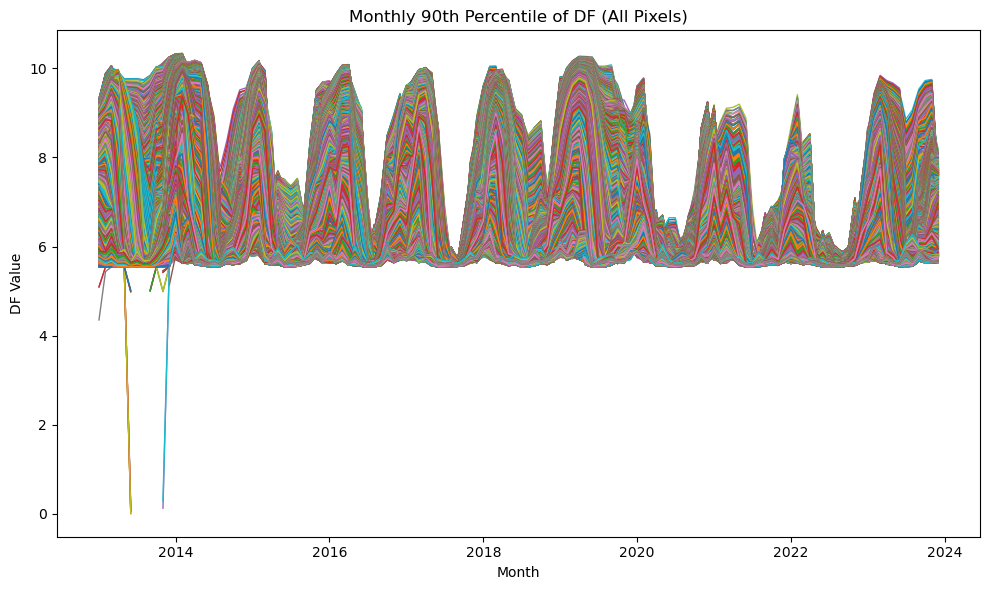

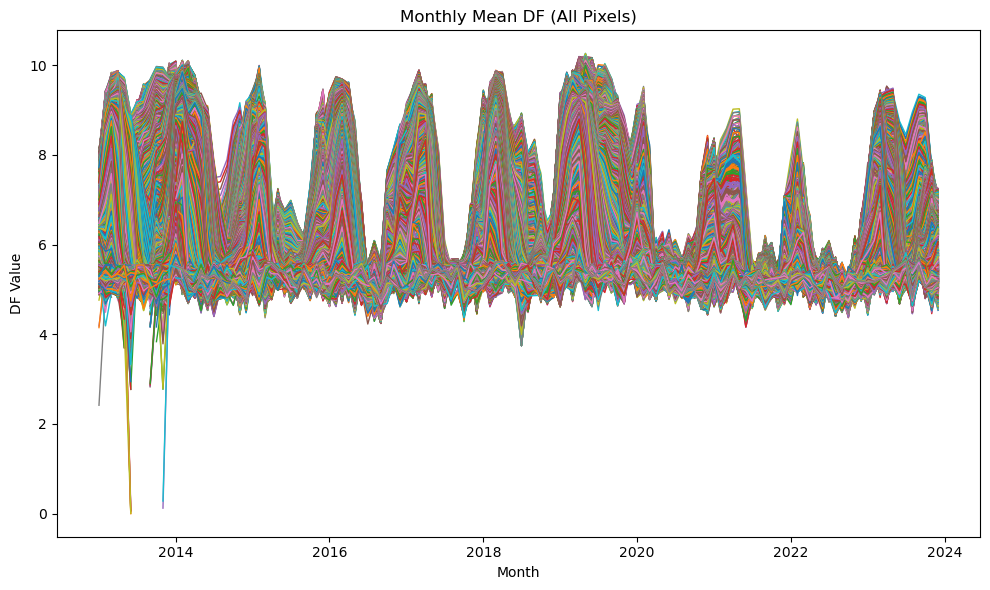

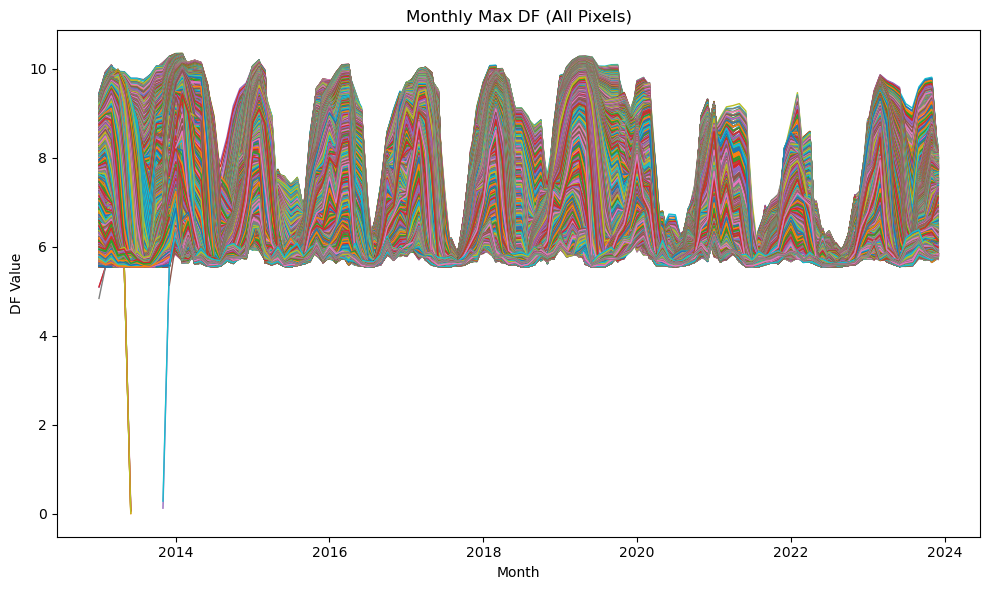

✅ Done! Plotted 4 separate graphs (80th, 90th, mean, max), each with a line per pixel.


In [22]:
# 4 – Summarise daily DF statistics
import re
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

# ------------------------------------------------------------------------
# 1) Setup: Paths, Input Files, Date Parsing
# ------------------------------------------------------------------------
df_folder = Path(r"C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final")  # Folder with daily DF rasters (DF_YYYY-MM-DD.tif)
df_files = sorted(df_folder.glob("DF_*.tif"))
if not df_files:
    print(f" No DF files found in {df_folder}")
    raise SystemExit

# Regex to extract date from filename (looks for something like "2020-06-15")
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")

# ------------------------------------------------------------------------
# 2) Load All Daily Rasters into a Single DataArray (time, y, x)
# ------------------------------------------------------------------------
list_of_days = []
for f in df_files:
    match = date_pattern.search(f.name)
    if not match:
        print(f"Skipping {f.name}: no date found.")
        continue
    
    # Parse the date string
    date_str = match.group(0)  # e.g. "2020-06-15"
    date_val = datetime.strptime(date_str, "%Y-%m-%d")

    # Read the raster
    da = rxr.open_rasterio(f).squeeze()  # shape => (y, x) after squeeze if there's a "band" dim
    # Add a single-element time dimension so we can concatenate
    da = da.expand_dims(dim={"time": [date_val]})
    
    list_of_days.append(da)

# Merge into one DataArray with dimension 'time'
df_data = xr.concat(list_of_days, dim="time")
df_data = df_data.sortby("time")  # sort by date just in case

# ------------------------------------------------------------------------
# 3) Resample from Daily to Monthly, per pixel
#    We compute 80th percentile, 90th percentile, mean, and max
# ------------------------------------------------------------------------
# "MS" means Month-Start frequency. If you prefer monthly-end grouping, use "M".
monthly_80   = df_data.resample(time="MS").quantile(0.8, dim="time", skipna=True)
monthly_90   = df_data.resample(time="MS").quantile(0.9, dim="time", skipna=True)
monthly_mean = df_data.resample(time="MS").mean(dim="time", skipna=True)
monthly_max  = df_data.resample(time="MS").max(dim="time", skipna=True)

# Each result is shape => (time, y, x), so each pixel has a monthly timeseries.

# ------------------------------------------------------------------------
# 4) Plotting Multiple Lines (One per Pixel) for Each Statistic
#    We'll create a helper function that stacks y,x => "pixel" dimension,
#    then loops to plot each pixel's timeseries on the same figure.
# ------------------------------------------------------------------------
def plot_all_pixels(da, title_str):
    """
    Plots each pixel's monthly timeseries from da (time, y, x) in one figure.
    """
    # stack y,x => single dimension "pixel" => shape (time, pixel)
    da_stacked = da.stack(pixel=("y", "x"))
    
    plt.figure(figsize=(10, 6))
    
    # For each pixel, plot its timeseries
    for px in da_stacked.pixel:
        series = da_stacked.sel(pixel=px)
        times  = series.time.values
        values = series.values
        plt.plot(times, values, linewidth=1)
    
    plt.title(title_str)
    plt.xlabel("Month")
    plt.ylabel("DF Value")
    plt.tight_layout()
    plt.show()

# 4a) 80th Percentile
plot_all_pixels(monthly_80, "Monthly 80th Percentile of DF (All Pixels)")

# 4b) 90th Percentile
plot_all_pixels(monthly_90, "Monthly 90th Percentile of DF (All Pixels)")

# 4c) Mean
plot_all_pixels(monthly_mean, "Monthly Mean DF (All Pixels)")

# 4d) Max
plot_all_pixels(monthly_max, "Monthly Max DF (All Pixels)")

print(" Done! Plotted 4 separate graphs (80th, 90th, mean, max), each with a line per pixel.")


## 5 – Visualise DF temporal trends

C:\Users\gades\AppData\Roaming\Python\Python39\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


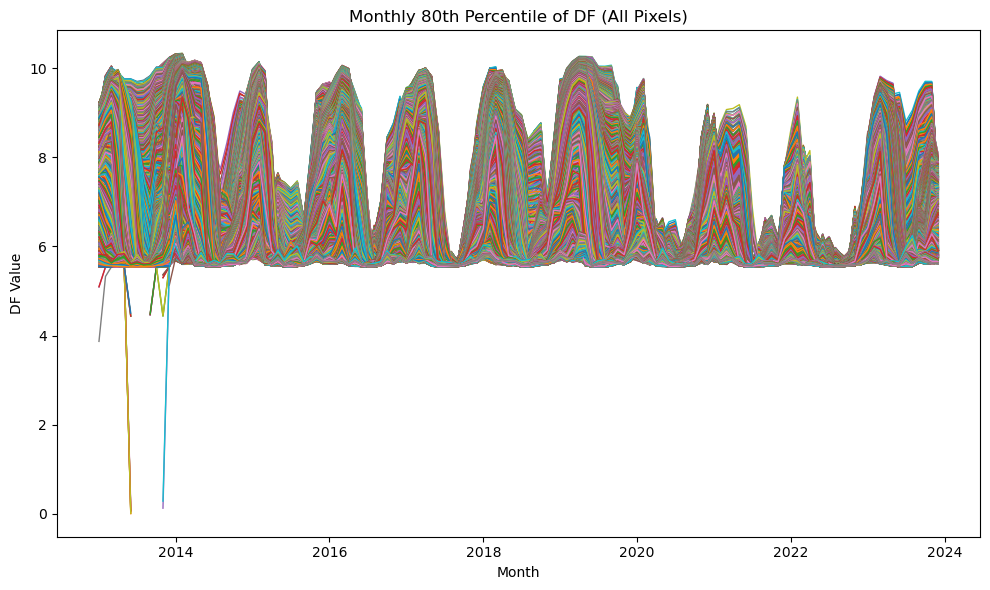

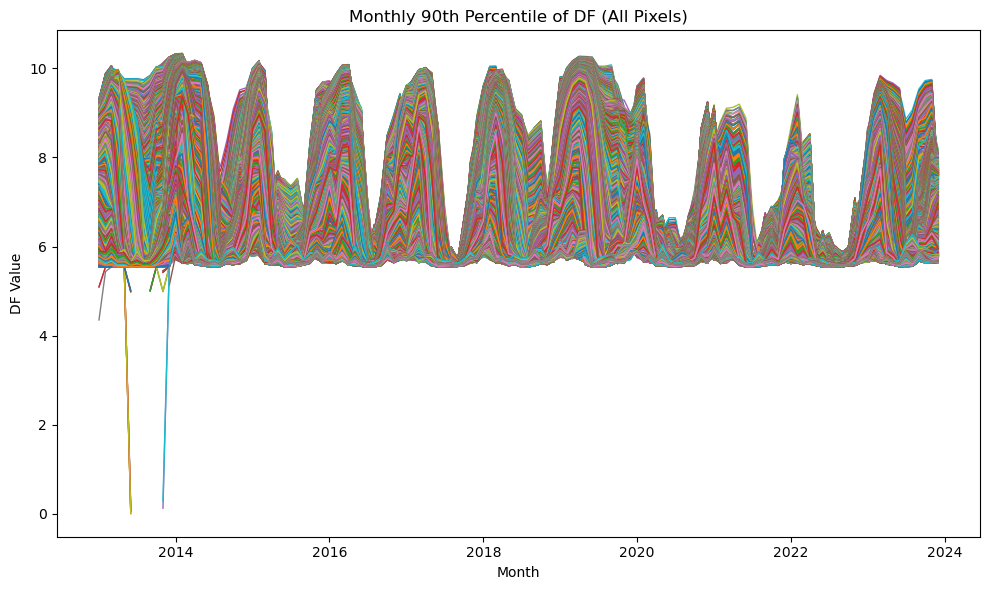

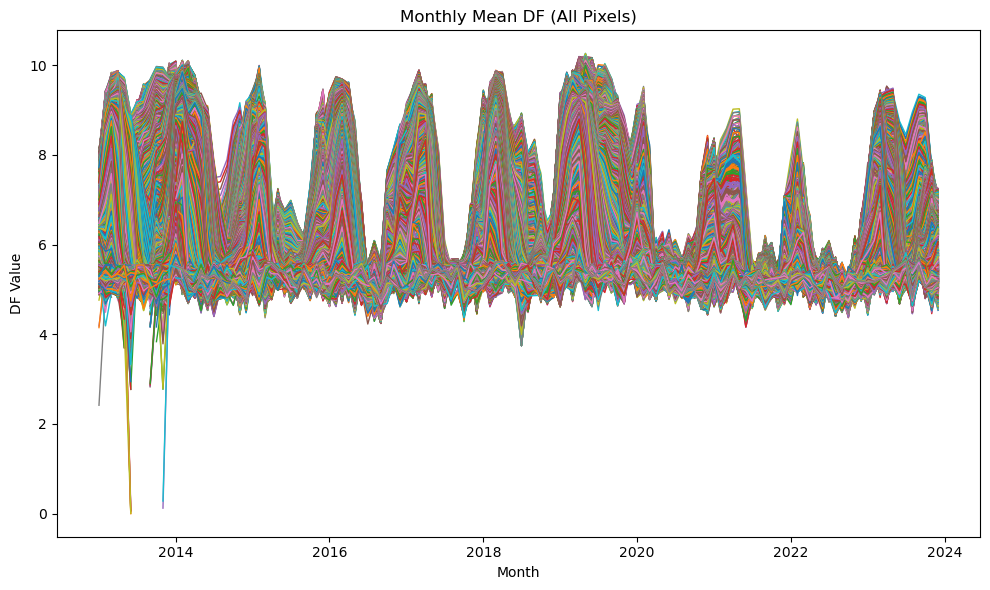

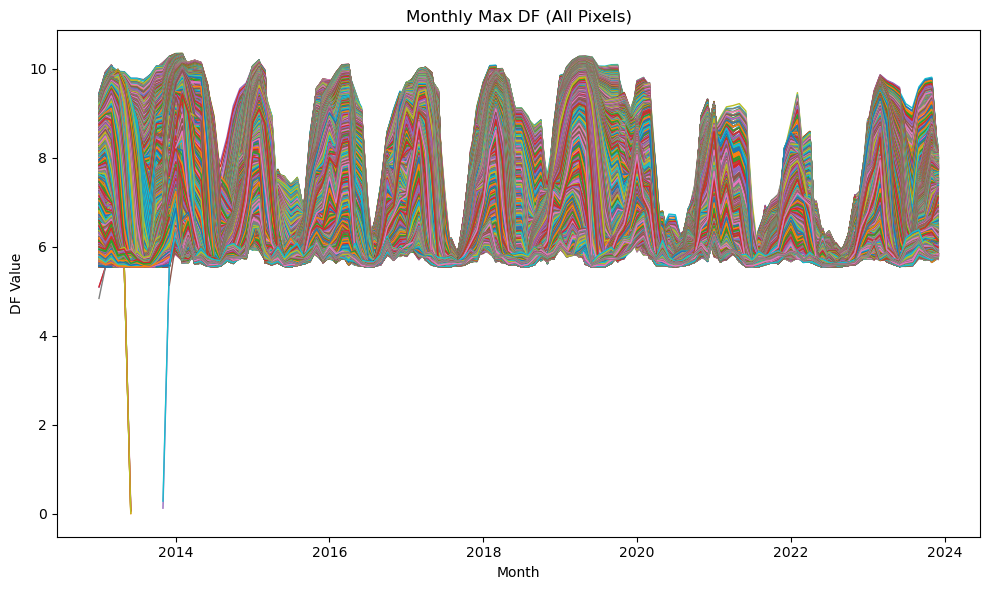

✅ Done! Plotted and saved 4 separate graphs (80th, 90th, mean, max).


In [5]:
# 5 – Visualise DF temporal trends
import re
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

# ------------------------------------------------------------------------
# 1) Setup: Paths, Input Files, Date Parsing
# ------------------------------------------------------------------------
df_folder = Path(r"C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final")
df_files = sorted(df_folder.glob("DF_*.tif"))
if not df_files:
    print(f" No DF files found in {df_folder}")
    raise SystemExit

# Regex to extract date (e.g. "2020-06-15") from filename
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")

# ------------------------------------------------------------------------
# 2) Load All Daily Rasters into a Single DataArray (time, y, x)
# ------------------------------------------------------------------------
list_of_days = []
for f in df_files:
    match = date_pattern.search(f.name)
    if not match:
        print(f"Skipping {f.name}: no date found.")
        continue
    
    date_str = match.group(0)  # e.g. "2020-06-15"
    date_val = datetime.strptime(date_str, "%Y-%m-%d")

    # Read the raster
    da = rxr.open_rasterio(f).squeeze()  # shape => (y, x) after squeeze if there's a "band" dim
    # Add a single-element time dimension so we can concatenate
    da = da.expand_dims(dim={"time": [date_val]})
    
    list_of_days.append(da)

# Merge into one DataArray with dimension 'time'
df_data = xr.concat(list_of_days, dim="time")
df_data = df_data.sortby("time")  # sort by date just in case

# ------------------------------------------------------------------------
# 3) Resample from Daily to Monthly, per pixel
#    We compute 80th percentile, 90th percentile, mean, and max
# ------------------------------------------------------------------------
monthly_80   = df_data.resample(time="MS").quantile(0.8, dim="time", skipna=True)
monthly_90   = df_data.resample(time="MS").quantile(0.9, dim="time", skipna=True)
monthly_mean = df_data.resample(time="MS").mean(dim="time", skipna=True)
monthly_max  = df_data.resample(time="MS").max(dim="time", skipna=True)

# ------------------------------------------------------------------------
# 4) Plotting Multiple Lines (One per Pixel)
# ------------------------------------------------------------------------
def plot_all_pixels(da, title_str):
    """
    Plots each pixel's monthly timeseries from da (time, y, x) in one figure.
    """
    # Stack y,x => single dimension "pixel" => shape (time, pixel)
    da_stacked = da.stack(pixel=("y", "x"))
    
    plt.figure(figsize=(10, 6))
    
    # For each pixel, plot its timeseries
    for px in da_stacked.pixel:
        series = da_stacked.sel(pixel=px)
        times  = series.time.values
        values = series.values
        plt.plot(times, values, linewidth=1)
    
    plt.title(title_str)
    plt.xlabel("Month")
    plt.ylabel("DF Value")
    plt.tight_layout()

# ------------------------------------------------------------------------
# 5) Create & Save Each Plot
# ------------------------------------------------------------------------

# 80th Percentile
plot_all_pixels(monthly_80, "Monthly 80th Percentile of DF (All Pixels)")
plt.savefig("monthly_80.png", dpi=150)  # <-- Save figure
plt.show()                             # <-- Show figure

# 90th Percentile
plot_all_pixels(monthly_90, "Monthly 90th Percentile of DF (All Pixels)")
plt.savefig("monthly_90.png", dpi=150)
plt.show()

# Mean
plot_all_pixels(monthly_mean, "Monthly Mean DF (All Pixels)")
plt.savefig("monthly_mean.png", dpi=150)
plt.show()

# Max
plot_all_pixels(monthly_max, "Monthly Max DF (All Pixels)")
plt.savefig("monthly_max.png", dpi=150)
plt.show()

print(" Done! Plotted and saved 4 separate graphs (80th, 90th, mean, max).")


## 6 – Extract max DF values by date

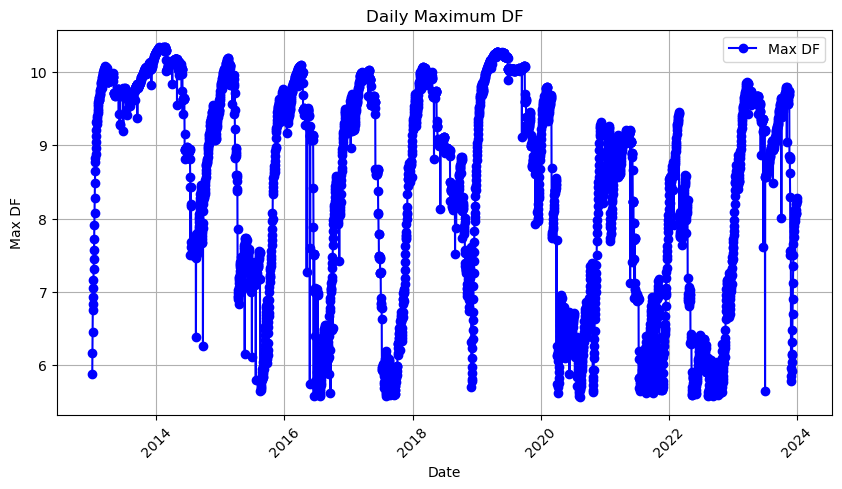

In [8]:
# 6 – Extract max DF values by date
import os
import re
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Folder containing the DF TIFF files
folder_path = r"C:/Users/gades/Desktop/Thesis/datasets/PRECPITATION_MERGED/precipitation_daily/df_final"  # Change this to your DF folder path

# Regular expression pattern to extract date from filename (e.g. DF_YYYY-MM-DD.tif)
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2}")

# Dictionary to store max DF values by date
df_data = {}

# Process each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):  # Ensure it's a .tif file
        match = date_pattern.search(filename)
        if match:
            date_str = match.group()
            date_val = datetime.strptime(date_str, "%Y-%m-%d").date()
            
            # Open the raster file
            file_path = os.path.join(folder_path, filename)
            with rasterio.open(file_path) as dataset:
                df_array = dataset.read(1)  # Read the first band
                df_max = np.nanmax(df_array)  # Get the max DF value
                
                # Store max value for that date
                df_data[date_val] = df_max

# Convert the dictionary to a Pandas DataFrame
df_plot = pd.DataFrame(list(df_data.items()), columns=["Date", "Max DF"])
df_plot.sort_values("Date", inplace=True)

# Plot the max DF values over time
plt.figure(figsize=(10, 5))
plt.plot(df_plot["Date"], df_plot["Max DF"], marker="o", linestyle="-", color="b", label="Max DF")
plt.xlabel("Date")
plt.ylabel("Max DF")
plt.title("Daily Maximum DF")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Save and show
plt.savefig("df_plot.png", dpi=150)
plt.show()
